In [185]:
import requests
import json
import prettytable
import pandas as pd
import datetime


#US bureu key is f6ddb520602b492e927bd727277959bd

In [4]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['CUUR0000SA0', 'CUUR0000SAF11', 'CUUR0000SEFV' ,'CUUR0000SACE', 'CUUR0000SEHF', 'CUUR0000SACL1E','CUUR0000SASLE'],"startyear":"2002", "endyear":"2022", 
                   "registrationkey":"f6ddb520602b492e927bd727277959bd"})

#data = json.dumps({"seriesid": ['CUUR0000SAF11'],"startyear":"2011", "endyear":"2022", 
                   #"registrationkey":"f6ddb520602b492e927bd727277959bd"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)
for series in json_data['Results']['series']:
    x=prettytable.PrettyTable(["series id","year","period","value","footnotes"])
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        period = item['period']
        date = datetime.date(year=int(year), month=int(period[-2:]), day=1)
        value = item['value']
        footnotes=""
        for footnote in item['footnotes']:
            if footnote:
                footnotes = footnotes + footnote['text'] + ','
        if 'M01' <= period <= 'M12':
            x.add_row([seriesId,year,period,value,date])
    output = open(seriesId + '.txt','w')
    output.write (x.get_string())
    output.close()

In [1]:
#print(x)

In [192]:
a

,series id,year,period,value,date
0,CUUR0000SA0,2021,M06,271.696,2021-06-01
1,CUUR0000SA0,2021,M05,269.195,2021-05-01
2,CUUR0000SA0,2021,M04,267.054,2021-04-01
3,CUUR0000SA0,2021,M03,264.877,2021-03-01
4,CUUR0000SA0,2021,M02,263.014,2021-02-01
...,...,...,...,...,...
1633,CUUR0000SASLE,2002,M05,216.6,2002-05-01
1634,CUUR0000SASLE,2002,M04,216.3,2002-04-01
1635,CUUR0000SASLE,2002,M03,215.9,2002-03-01
1636,CUUR0000SASLE,2002,M02,215.1,2002-02-01


In [186]:
x=prettytable.PrettyTable(["series id","year","period","value","footnotes"])
result = list()
for series in json_data['Results']['series']:
    seriesId = series['seriesID']
    print(seriesId)
    for item in series['data']:
        year = item['year']
        period = item['period']
        value = item['value']
        date = datetime.date(year=int(year), month=int(period[-2:]), day=1)

        footnotes=""
        for footnote in item['footnotes']:
            if footnote:
                footnotes = footnotes + footnote['text'] + ','
        if 'M01' <= period <= 'M12':
            x.add_row([seriesId,year,period,value,footnotes[0:-1]])
            result.append((seriesId,year,period,value,date))
    #output = open(seriesId + '.txt','w')
    #output.write (x.get_string())
    #output.close()

CUUR0000SA0
CUUR0000SAF11
CUUR0000SEFV
CUUR0000SACE
CUUR0000SEHF
CUUR0000SACL1E
CUUR0000SASLE


In [187]:
a = pd.DataFrame(result, columns=["series id","year","period","value","date"])

In [188]:
b = a[a['series id']== "CUUR0000SA0"]["value"].astype(float).pct_change(periods=-12)

In [13]:
b[::-1].dropna()

221    0.025974
220    0.029809
219    0.030201
218    0.022247
217    0.020578
         ...   
4      0.016762
3      0.026198
2      0.041597
1      0.049927
0      0.053915
Name: value, Length: 222, dtype: float64

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

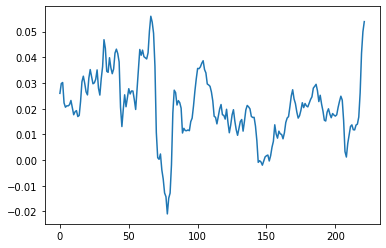

In [15]:
fig = plt.figure()
ax = plt.axes()
ax.plot(np.linspace(0, 221,222),  b[::-1].dropna())

In [184]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
b = a[a['series id']== "CUUR0000SA0"]
b["CPI"] = b["value"].astype(float).pct_change(periods=-12)
sns.lineplot(x="date", y="CPI",
             data=b)

TypeError: list indices must be integers or slices, not str

In [190]:
b

0      0.053915
1      0.049927
2      0.041597
3      0.026198
4      0.016762
         ...   
229         NaN
230         NaN
231         NaN
232         NaN
233         NaN
Name: value, Length: 234, dtype: float64

CUUR0000SA0
CUUR0000SAF11
CUUR0000SACE
CUUR0000SEFV
CUUR0000SEHF
CUUR0000SACL1E
CUUR0000SASLE


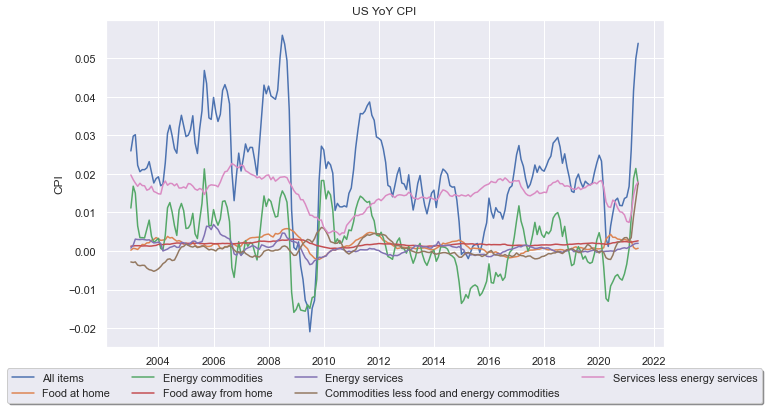

In [193]:
# Convention for import of the pyplot interface
import matplotlib.pyplot as plt

# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline

series = ['CUUR0000SA0', 'CUUR0000SAF11', 'CUUR0000SACE','CUUR0000SEFV' ,'CUUR0000SEHF', 'CUUR0000SACL1E','CUUR0000SASLE']
s_name = ['All items', 'Food at home', 'Energy commodities', 'Food away from home', 'Energy services', 
          'Commodities less food and energy commodities', 'Services less energy services' ]
s_weights = [1, 0.07647, 0.03929, 0.06226, 0.03144, 0.20473, 0.5858]
name_dict = {}
weights_dict = {}
data_dict = {}
for i in range(len(series)):
    name_dict[series[i]] = s_name[i]
    weights_dict[series[i]] = s_weights[i]

    
fig, ax = plt.subplots(figsize=(10, 6))
#axb = ax.twinx()

# Same as above
ax.set_xlabel('Year')
ax.set_ylabel('CPI')
ax.set_title('US YoY CPI')
ax.grid(True)


# Plotting on the first y-axis
b["date"] = a[a['series id']== 'CUUR0000SA0']["date"]
for s in series:
    if s != "":
        #b = a[a['series id']== s]
        print(s)
        data_dict[s] = a[a['series id']== s]["value"].astype(float).pct_change(periods=-12)*weights_dict[s]


        ax.plot(b["date"], data_dict[s], label=name_dict[s])
    #ax.plot(df.time, df.wind_gust, color='tab:olive', linestyle='--', label='Wind Gust')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=4)

In [157]:
c = pd.DataFrame()
c['date']= b['date']
c["agr"] = 0
for s in series:
    if s != "CUUR0000SA0":
        #print(s, data_dict[s])
        c[s] = np.array(data_dict[s])
        c["agr"] += c[s]

In [53]:
import numpy as np

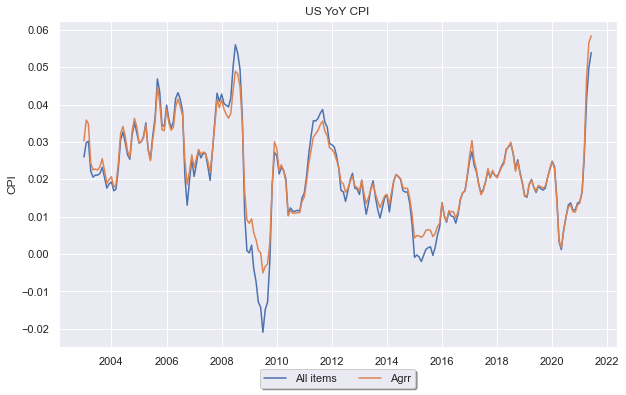

In [158]:
fig, ax = plt.subplots(figsize=(10, 6))
#axb = ax.twinx()

# Same as above
ax.set_xlabel('Year')
ax.set_ylabel('CPI')
ax.set_title('US YoY CPI')
ax.grid(True)

ax.plot(b["date"], data_dict["CUUR0000SA0"], label=name_dict["CUUR0000SA0"])
ax.plot(c['date'], c["agr"], label="Agrr")

    #ax.plot(df.time, df.wind_gust, color='tab:olive', linestyle='--', label='Wind Gust')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=4)

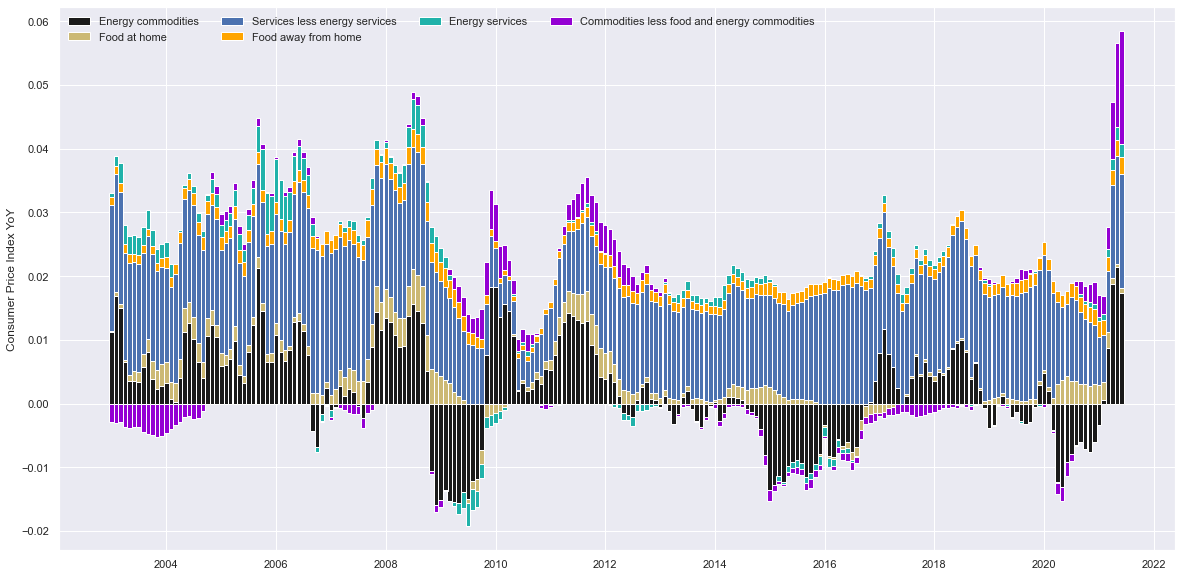

In [245]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


series = ['CUUR0000SACE','CUUR0000SAF11','CUUR0000SASLE', 'CUUR0000SEFV' ,'CUUR0000SEHF', 'CUUR0000SACL1E']
s_name = ['Energy commodities','Food at home','Services less energy services',  'Food away from home', 'Energy services', 
          'Commodities less food and energy commodities' ]
s_weights = [0.03929,0.07647,0.5858,  0.06226, 0.03144, 0.20473]

c = pd.DataFrame()
c['date']= b['date']
c["agr"] = 0

for s in series:
        #print(s, data_dict[s])
    c[s] = np.array(data_dict[s])
    c["agr"] += c[s]        
c = c.dropna()
fig, ax = plt.subplots(figsize=(20, 10))
#axb = ax.twinx()

# Same as above
ax.set_ylabel('Consumer Price Index YoY')
#ax.set_title('US YoY CPI Contributions by Categories', fontsize = 16)
#ax.grid(True)

temp = np.array(c[['CUUR0000SACE','CUUR0000SAF11','CUUR0000SASLE', 'CUUR0000SEFV' ,'CUUR0000SEHF', 'CUUR0000SACL1E']])
temp = temp.swapaxes(0,1)

cumulated_data = get_cumulated_array(temp, min=0)
cumulated_data_neg = get_cumulated_array(temp, max=0)
row_mask = (temp<0)
cumulated_data[row_mask] = cumulated_data_neg[row_mask]
data_stack = cumulated_data

data_shape = np.shape(temp)

cols = ["k", "y", "b", "orange", "lightseagreen", "darkviolet"]

for i in np.arange(0, data_shape[0]):
    ax.bar(c["date"], temp[i], bottom=data_stack[i], color=cols[i],width = 30)

#plt.show()

"""d = c.dropna()
# plot bars
bottom = len(d) * [0]

for s in series:
    if s != "CUUR0000SA0":
        print(s)
        
        plt.bar(d["date"], d[s],width=30, bottom = bottom)
        bottom = bottom + d[s]
"""
# twin object for two different y-axis on the sample plot
#ax2=ax.twinx()
#color = 'tab:red'

# make a plot with different y-axis using second axis object
#ax2.plot(gapminder_us.year, gapminder_us["gdpPercap"],color="blue",marker="o")
#ax2.set_ylabel("gdpPercap",color="blue",fontsize=14)  
#ax2 = sns.lineplot(x=c["date"], y = c["agr"],  sort=False, color='r')
# view data
#print(d)
#plt.show()
 
plt.legend(s_name,  ncol=4, frameon=False)

In [178]:
a = [4,-6,9]
b = [2,7,1]
c = [3,3,1]
d = [4,0,-3]
data = np.array([a, b, c, d])
data_shape = np.shape(data)

# Take negative and positive data apart and cumulate
def get_cumulated_array(data, **kwargs):
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d  

cumulated_data = get_cumulated_array(data, min=0)
cumulated_data_neg = get_cumulated_array(data, max=0)

# Re-merge negative and positive data.
row_mask = (data<0)
cumulated_data[row_mask] = cumulated_data_neg[row_mask]
data_stack = cumulated_data

In [218]:
temp

array([[ 0.01737386,  0.0007106 ,  0.01795851,  0.00263611,  0.00198922,
         0.01772986],
       [ 0.02142072,  0.00050884,  0.01695192,  0.00251252,  0.00196087,
         0.01325066],
       [ 0.01880671,  0.00092444,  0.0145076 ,  0.00239495,  0.00171192,
         0.00898393],
       ...,
       [ 0.01501413,  0.00060725,  0.01763641,  0.00137106,  0.00307905,
        -0.00283167],
       [ 0.01682165,  0.00069518,  0.01851901,  0.00130148,  0.00151663,
        -0.0029815 ],
       [ 0.01115789,  0.000217  ,  0.0197276 ,  0.00123532,  0.00075988,
        -0.00284941]])

In [219]:
temp = np.array(c[['CUUR0000SACE','CUUR0000SAF11','CUUR0000SASLE', 'CUUR0000SEFV' ,'CUUR0000SEHF', 'CUUR0000SACL1E']].dropna())
temp = temp.swapaxes(0,1)

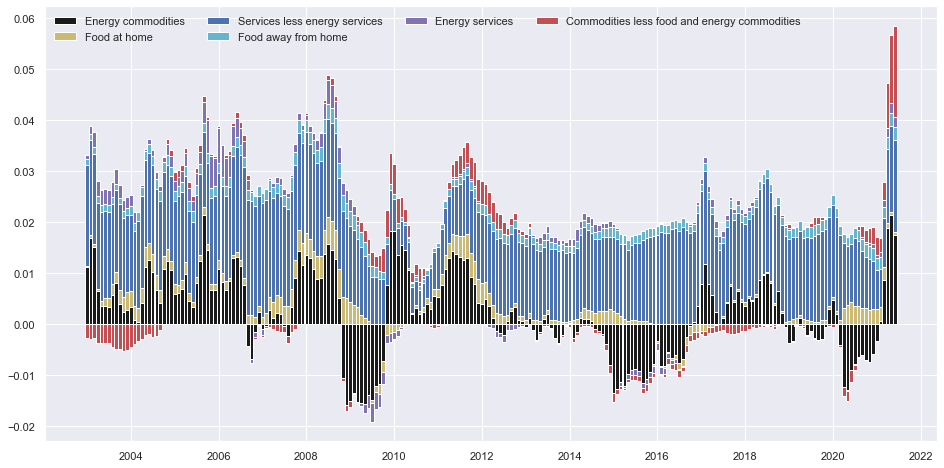

In [235]:
cumulated_data = get_cumulated_array(temp, min=0)
cumulated_data_neg = get_cumulated_array(temp, max=0)
row_mask = (temp<0)
cumulated_data[row_mask] = cumulated_data_neg[row_mask]
data_stack = cumulated_data

data_shape = np.shape(temp)

cols = ["k", "y", "b", "c", "m", "r"]


fig, ax = plt.subplots(figsize=(16, 8))

for i in np.arange(0, data_shape[0]):
    ax.bar(c["date"], temp[i], bottom=data_stack[i], width = 30, color=cols[i],)
plt.legend(s_name,  ncol=4, frameon=False)
plt.show()

In [226]:
temp[0]

array([ 1.73738580e-02,  2.14207179e-02,  1.88067052e-02,  8.65094829e-03,
        6.13969310e-04, -3.41269310e-03, -5.96991132e-03, -7.56933311e-03,
       -7.10388657e-03, -6.10583011e-03, -6.58071371e-03, -7.94304993e-03,
       -9.10624205e-03, -1.30565650e-02, -1.23265601e-02, -4.08026178e-03,
        1.96072336e-03,  4.76241851e-03,  2.90480263e-03, -5.95285785e-04,
       -2.91873502e-03, -3.21580813e-03, -2.77060974e-03, -1.32967774e-03,
       -2.11325638e-03, -1.07283670e-04,  1.14176641e-03, -2.51222606e-04,
       -3.39078958e-03, -3.80558084e-03, -6.87609009e-04,  2.13219756e-03,
        6.39675467e-03,  3.77764667e-03,  8.03259107e-03,  9.97767120e-03,
        9.53550640e-03,  8.53567447e-03,  5.36381510e-03,  4.45231155e-03,
        5.01698054e-03,  3.51657690e-03,  4.26048178e-03,  6.45469305e-03,
        4.25395225e-03,  7.43217922e-03,  4.04030732e-03,  1.23293409e-03,
       -8.98258182e-06,  2.39187912e-03,  5.70064234e-03,  7.77446653e-03,
        1.17275489e-02,  

In [217]:
data_stack[1]

array([0.01737386, 0.0007106 , 0.01795851, 0.00263611, 0.00198922,
       0.01772986])